## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Installing and Importing the necessary libraries**

In [1]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install numpy==1.26.4 \
             scikit-learn==1.6.1 \
             scipy==1.13.1 \
             gensim==4.3.3 \
             sentence-transformers==3.4.1 \
             pandas==2.2.2

Note:
- After running the above cell, kindly restart the runtime (for Google Colab) or notebook kernel (for Jupyter Notebook), and run all cells sequentially from the next cell.
- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [6]:
# to read and manipulate the data
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', None)    # setting column to the maximum column width as per the data

# to visualise data
import matplotlib.pyplot as plt
import seaborn as sns

# To import Word2Vec
from gensim.models import Word2Vec

# Deep Learning library
import torch

# to load transformer models
from sentence_transformers import SentenceTransformer
from transformers import T5Tokenizer, T5ForConditionalGeneration, pipeline

# To split data into train and test sets
from sklearn.model_selection import train_test_split

# To build a Random Forest model
from sklearn.ensemble import RandomForestClassifier

# To compute metrics to evaluate the model
from sklearn.metrics import accuracy_score, confusion_matrix

# to ignore unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

# Import TensorFlow and Keras for deep learning model building.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

## **Loading the dataset**

In [13]:
# Load the dataset from the GitHub repository
import pandas as pd
url = 'https://raw.githubusercontent.com/yush582/StockNews/main/stock_news.csv'
stock_news = pd.read_csv(url)
stock_news.head()

,Date,News,Open,High,Low,Close,Volume,Label
0,01-02-2019,The dollar minutes ago tumbled to 106 67 from above 109 a few trades earlier It s since bounced a hair to 107 16 FXY 3 6 after hoursAlongside money poured into U S government paper with the 10 year Treasury yield sliding a few more basis points to 2 61 TLT 0 7 after hour Both moves come following Apple NASDAQ AAPL s revenue warning which sent its shares and U S stock index futures into the red Apple s currently off 7 5 and the QQQs 2 2 ETFs TLT TBT TMV FXY YCS TBF EDV TMF TTT ZROZ VGLT OTC JYN TLH UBT SPTL YCL DLBS VUSTX TYBS DLBL OLD DJPY OPER UJPYNow read,38.72,39.71,38.56,39.48,130672400,1
1,01-02-2019,By Wayne Cole and Swati Pandey SYDNEY Reuters The Japanese yen soared in early Asian trading on Thursday as the break of key technical levels triggered massive stop loss sales of the U S and Australian dollars in very thin markets The dollar collapsed to as low as 105 25 yen on Reuters dealing a drop of 3 2 percent from the opening 108 76 and the lowest reading since March 2018 It was last trading around 107 50 yen Analysts said the rot began when tech bellwether Apple Inc O AAPL shocked investors by cutting its earnings guidance citing sluggish iPhone sales in China The news sent U S stock futures sliding and sparked a rush of funds to safe haven bonds With risk aversion high the safe haven yen was propelled through major technical levels and triggered massive stop loss flows from investors who have been short of the yen for months The move was exacerbated by a dearth of liquidity with Japan still on holiday after the New Year and by automated algorithmic trades which are carried out by computers in micro seconds Most major currencies simply collapsed against the yen in a matter of seconds Looks like we had a flash crash said Ray Attrill head of FX strategy at National Australia Bank One theory is that may be Japanese retail FX players are forcing out of AUDJPY which is creating a liquidity vacuum he added This is a market dislocation rather than a fundamental event The Australian dollar tumbled to as low as 72 26 yen AUDJPY D3 on Reuters dealing a level not seen since late 2011 having started around 75 21 It was last changing hands at 73 72 yen The Aussie in turn sank against the U S dollar to as far as 0 6715 the lowest since March 2009 having started around 0 6984 It was last trading at 0 6888 \nOther currencies smashed against the yen included the euro sterling and the Turkish lira,38.72,39.71,38.56,39.48,130672400,-1
2,01-02-2019,By Stephen Culp NEW YORK Reuters Wall Street edged higher on Wednesday after stumbling out of the starting gate on the first trading day of 2019 while fears of a global economic slowdown were exacerbated after Apple cut its holiday quarter revenue forecast Apple O AAPL dropped 8 percent in extended trading late in the day after the iPhone maker slashed its outlook for the December quarter blaming weak demand in China Shares of Apple s suppliers also fell and S P 500 futures dropped 1 3 percent signaling that Wednesday s modest advance could unwind when the market reopens on Thursday To see Apple s sales drop off this much says something about the Chinese economy said Tim Ghriskey chief investment strategist at Inverness Counsel in New York Any company that does business in China will feel the impact of this Stocks had started the session lower after separate reports showed a deceleration in factory activity in China and the euro zone indicating the ongoing trade dispute between the United States and China was taking a toll on global manufacturing Energy SPNY stocks led the S P 500 s advance and the sector was the index s biggest percentage gainer buoyed by a 2 4 percent jump in crude prices The group was the worst performing S P sector in 2018 Gains were offset by healthcare SPXHC and so called defensive sectors such as real estate utilities SPLRCU and consumer staples SPLRCS Healthcare companies provided the biggest drag on the S P 500 a

In [14]:
data = stock_news.copy()

## **Data Overview**

In [15]:
data.shape

(418, 8)

In [16]:
data.isnull().sum()

,0
Date,0
News,0
Open,0
High,0
Low,0
Close,0
Volume,0
Label,0


In [17]:
data.duplicated().sum()

0

In [18]:
data = data.drop_duplicates(keep='first')

In [19]:
data = data.reset_index(drop=True)

## **Exploratory Data Analysis**

### **Univariate Analysis**

* Distribution of individual variables
* Compute and check the distribution of the length of news content

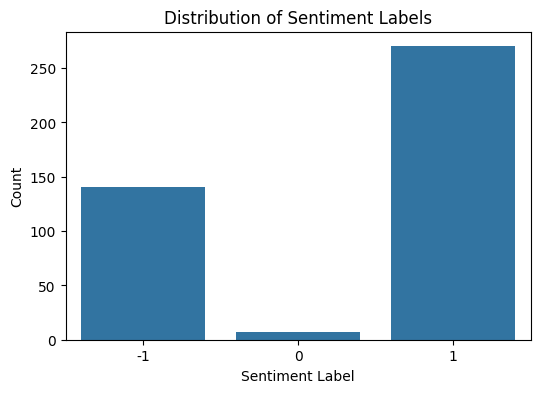

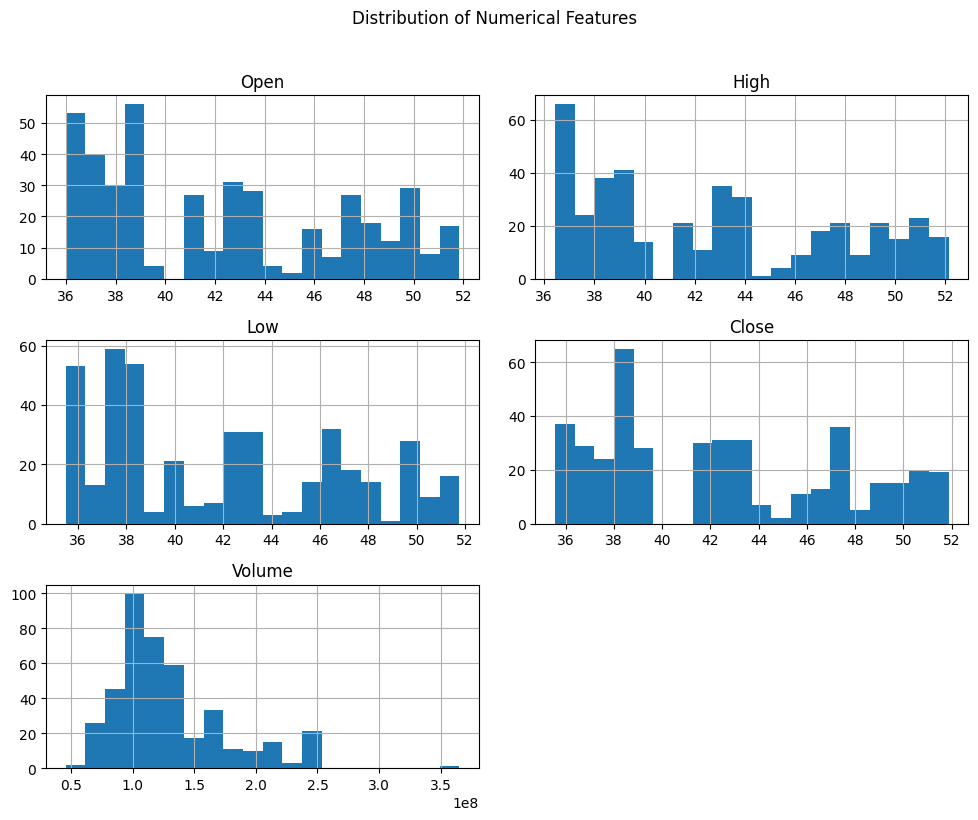

In [20]:
# Distribution of the 'Label' column
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='Label')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()

# Distribution of the numerical features
numerical_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
data[numerical_cols].hist(figsize=(10, 8), bins=20)
plt.suptitle('Distribution of Numerical Features', y=1.02)
plt.tight_layout()
plt.show()

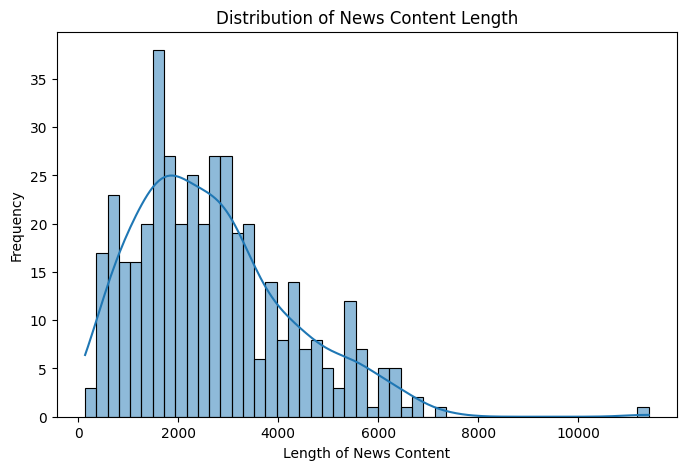

count      418.000000
mean      2667.988038
std       1567.143286
min        137.000000
25%       1541.250000
50%       2413.000000
75%       3495.500000
max      11406.000000
Name: News_Length, dtype: float64


In [21]:
# Compute the length of news content
data['News_Length'] = data['News'].apply(len)

# Distribution of the length of news content
plt.figure(figsize=(8, 5))
sns.histplot(data['News_Length'], bins=50, kde=True)
plt.title('Distribution of News Content Length')
plt.xlabel('Length of News Content')
plt.ylabel('Frequency')
plt.show()

# Display descriptive statistics for news length
print(data['News_Length'].describe())

### Univariate Analysis Results

The univariate analysis provided insights into the individual variables:

*   **Sentiment Label Distribution:** The sentiment labels are not evenly distributed, with a higher count of positive and negative labels compared to neutral. This indicates a potential class imbalance issue that might need to be addressed during model building.
*   **Numerical Feature Distributions:** The distributions of 'Open', 'High', 'Low', 'Close', and 'Volume' show the range and frequency of these stock price and volume data.
*   **News Content Length Distribution:** The majority of news articles have a length between approximately 1500 and 4000 characters, with a right skew indicating the presence of some longer articles.

### Additional Univariate Analysis

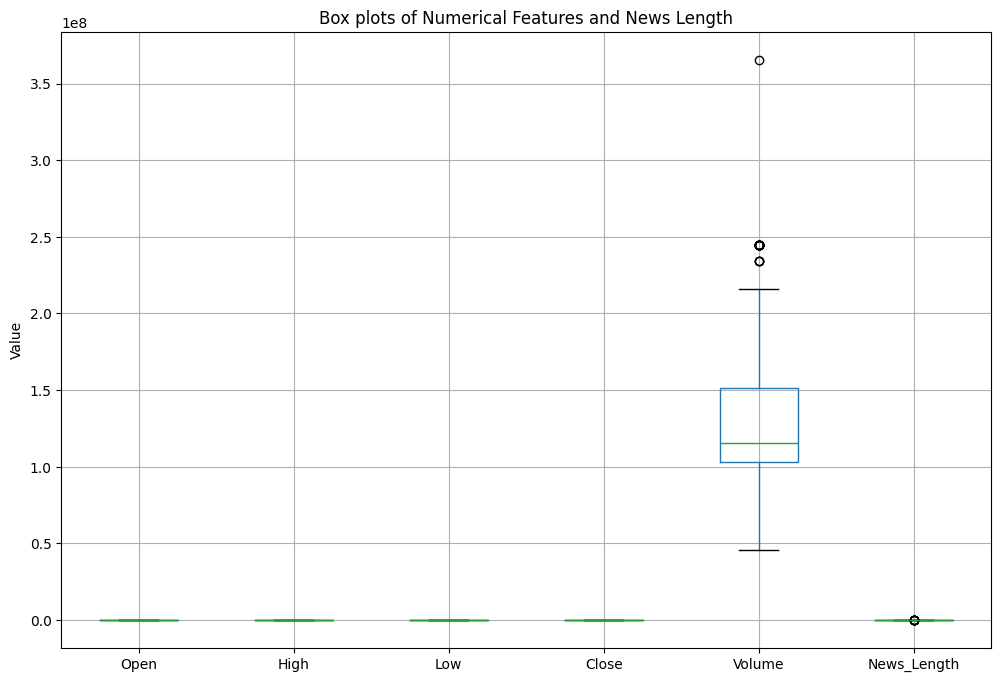

In [23]:
# Check for outliers in numerical features using box plots
numerical_cols_with_length = ['Open', 'High', 'Low', 'Close', 'Volume', 'News_Length']
plt.figure(figsize=(12, 8))
data[numerical_cols_with_length].boxplot()
plt.title('Box plots of Numerical Features and News Length')
plt.ylabel('Value')
plt.show()

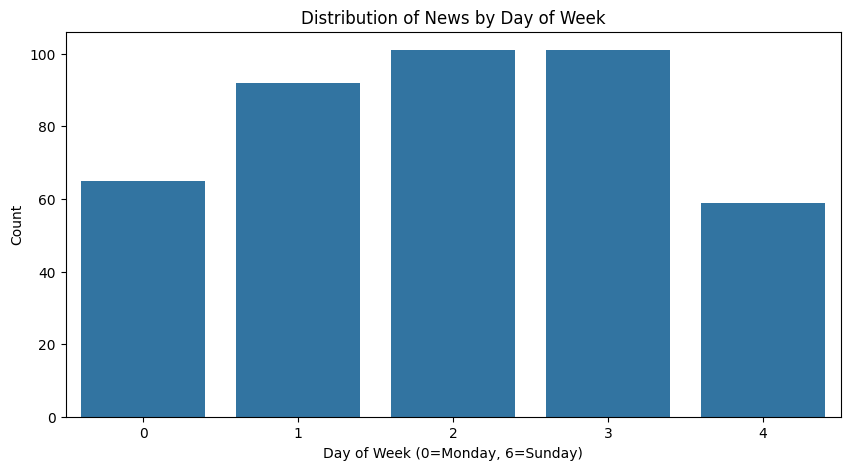

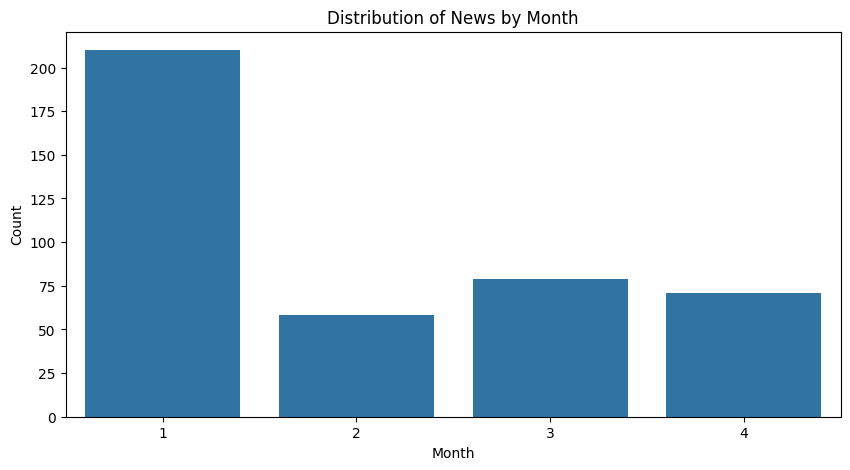

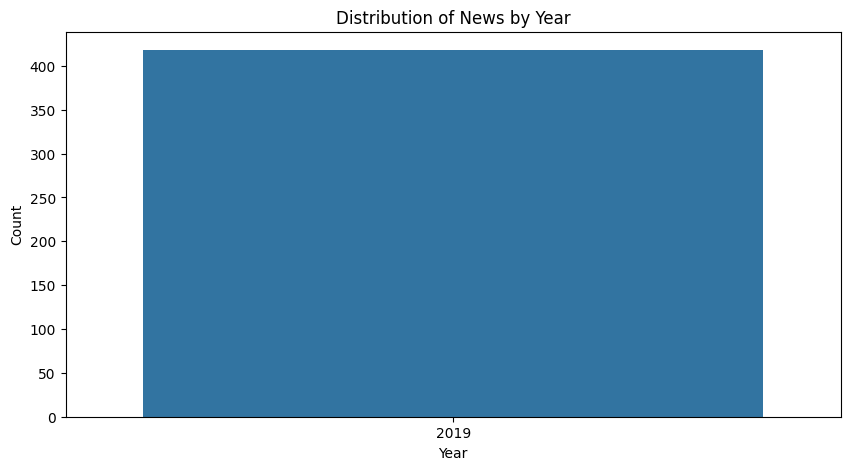

In [24]:
# Analyze Date variable
data['Date'] = pd.to_datetime(data['Date'], format='%m-%d-%Y')

data['Day_of_Week'] = data['Date'].dt.dayofweek
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year

plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='Day_of_Week')
plt.title('Distribution of News by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='Month')
plt.title('Distribution of News by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='Year')
plt.title('Distribution of News by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

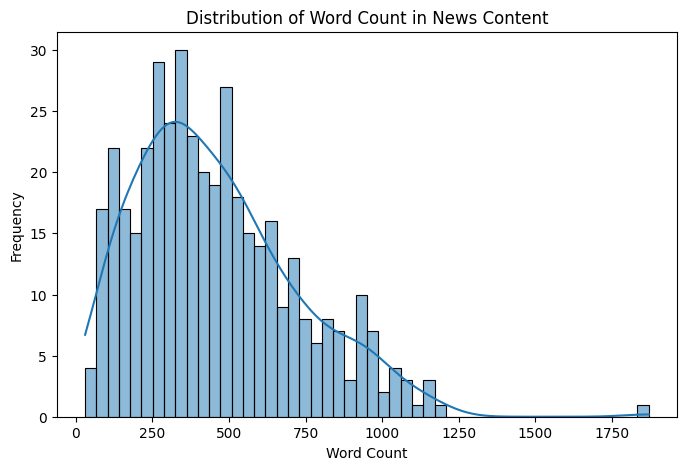

count     418.000000
mean      455.055024
std       266.019435
min        30.000000
25%       258.500000
50%       407.500000
75%       604.500000
max      1870.000000
Name: Word_Count, dtype: float64

20 Most Common Words (basic):
[('the', 8234), ('to', 4943), ('in', 4029), ('a', 3884), ('of', 3835), ('and', 3706), ('s', 2218), ('on', 2165), ('for', 1812), ('said', 1541), ('that', 1516), ('The', 1503), ('its', 1350), ('as', 1310), ('Apple', 1298), ('is', 1242), ('S', 1166), ('with', 1141), ('it', 1028), ('from', 1010)]


In [25]:
# Examine Text Characteristics of News Content
# Number of words in News Content
data['Word_Count'] = data['News'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))
sns.histplot(data['Word_Count'], bins=50, kde=True)
plt.title('Distribution of Word Count in News Content')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

print(data['Word_Count'].describe())

# Most common words (basic example, further text preprocessing would be needed for a more accurate analysis)
from collections import Counter
all_words = ' '.join(data['News']).split()
most_common_words = Counter(all_words).most_common(20)
print("\n20 Most Common Words (basic):")
print(most_common_words)

### Univariate Analysis Summary and Strategy Forward

The univariate analysis has provided valuable insights into the individual characteristics of our dataset:

*   **Sentiment Label Distribution:** We observed an imbalance in sentiment labels, with more positive and negative instances than neutral. This highlights the need to consider techniques like resampling or using appropriate evaluation metrics during model building to handle this imbalance effectively.
*   **Numerical Feature Distributions and Outliers:** The distributions of 'Open', 'High', 'Low', 'Close', and 'Volume' were visualized, showing their ranges and frequencies. The box plots helped identify potential outliers in these numerical features and news length, which might require attention during data preprocessing.
*   **Temporal Analysis of News:** By extracting the day of the week, month, and year from the 'Date' column, we gained an understanding of the distribution of news over time. This could be useful for identifying any temporal patterns or trends in the news frequency.
*   **Text Characteristics of News Content:** We analyzed the distribution of news content length and word count, and identified the most common words. This initial look into the text data provides a basic understanding of the news content and suggests the need for further text preprocessing and feature extraction.

**Strategy Forward:**

Based on the univariate analysis, the next steps should focus on:

1.  **Bivariate Analysis:** Explore the relationships between different variables, such as sentiment polarity and stock prices, or news characteristics and stock movements.
2.  **Data Preprocessing:** Address issues identified during univariate analysis, such as potential outliers and handling the class imbalance in sentiment labels. This will also involve text preprocessing steps to prepare the 'News' content for modeling.
3.  **Word Embeddings and Model Building:** Proceed with generating word embeddings and building sentiment analysis models as outlined in the subsequent sections of the notebook, keeping in mind the insights gained from the exploratory data analysis.

### **Bivariate Analysis**

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

**Note**: The above points are listed to provide guidance on how to approach bivariate analysis. Analysis has to be done beyond the above listed points to get maximum scores.

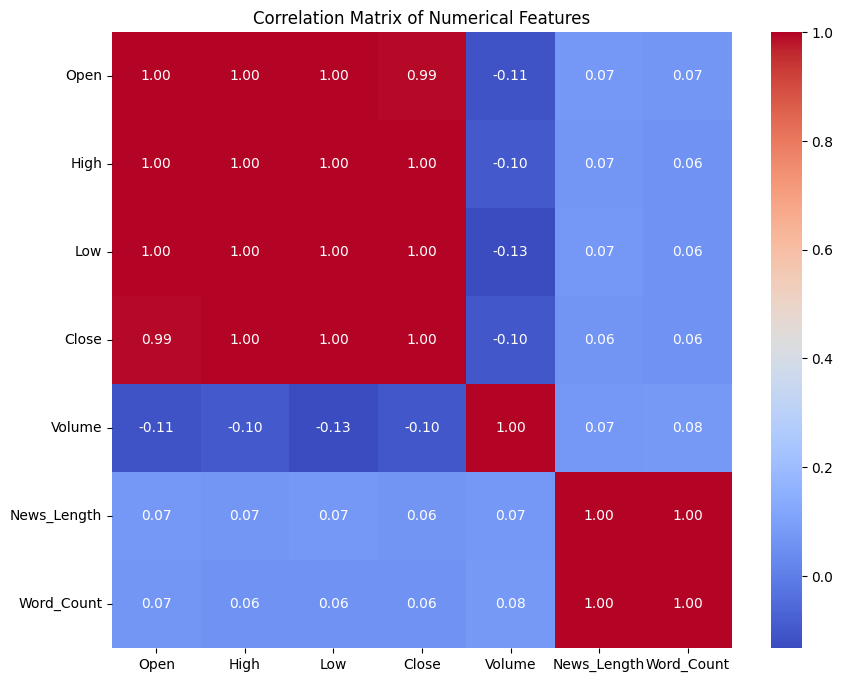

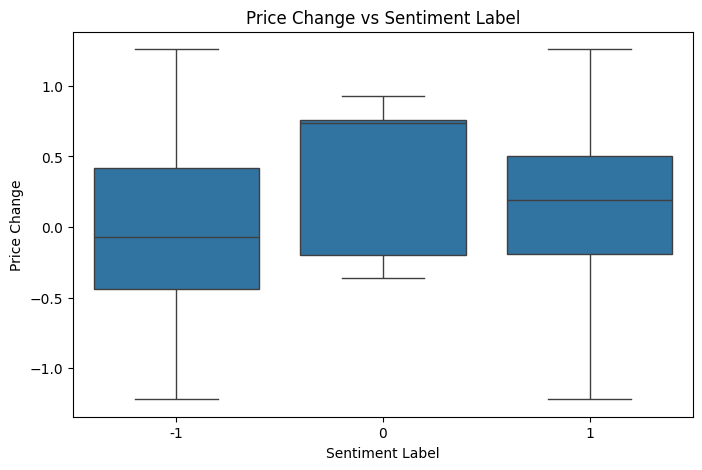

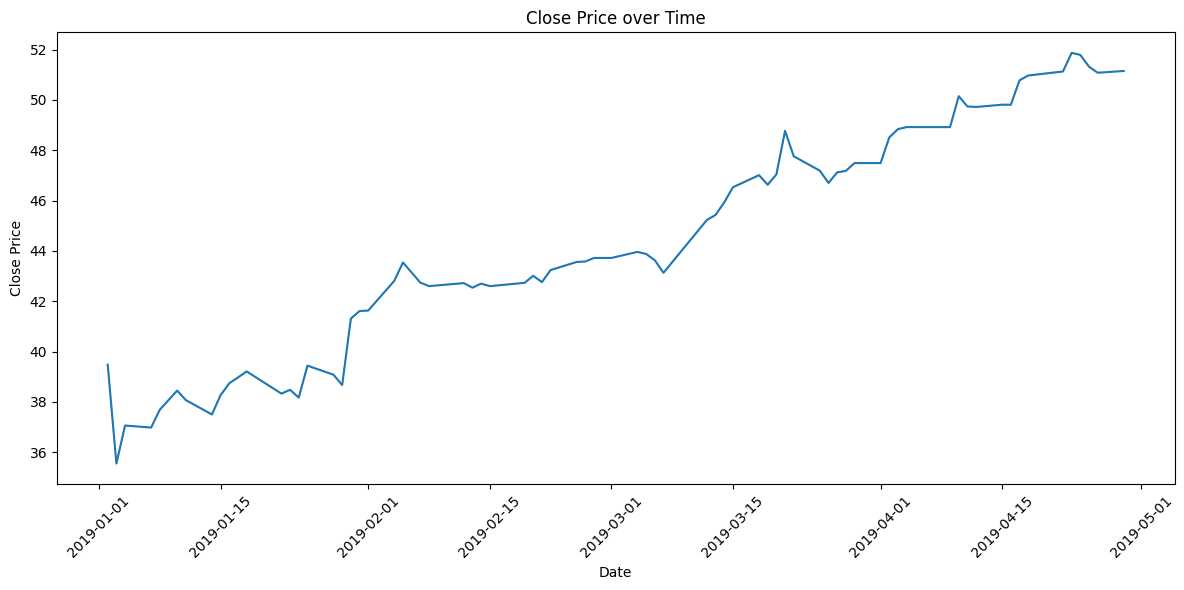

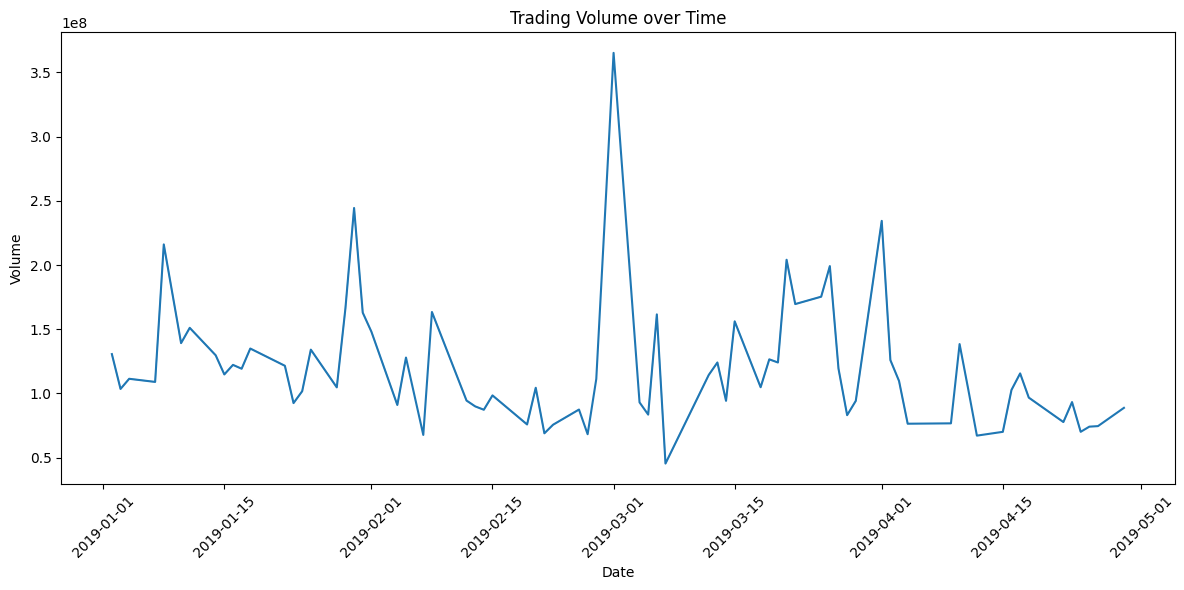

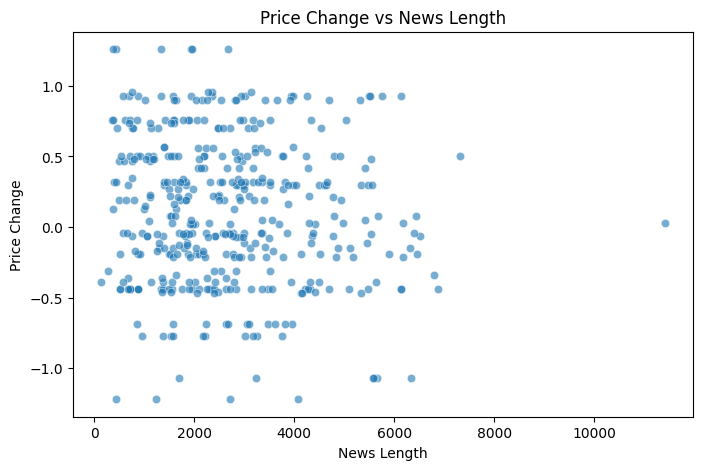

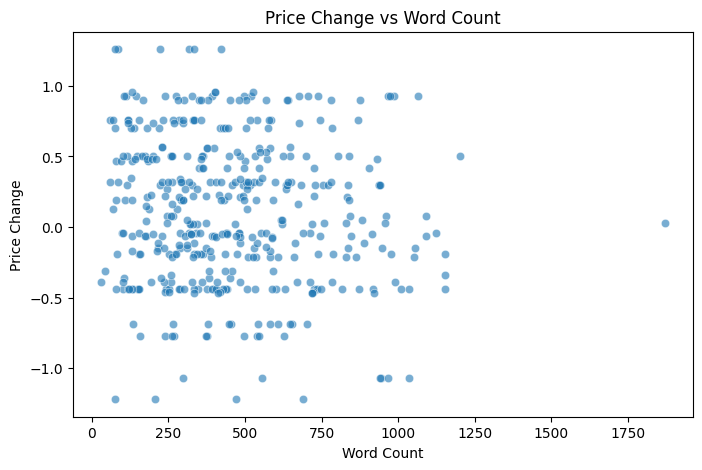

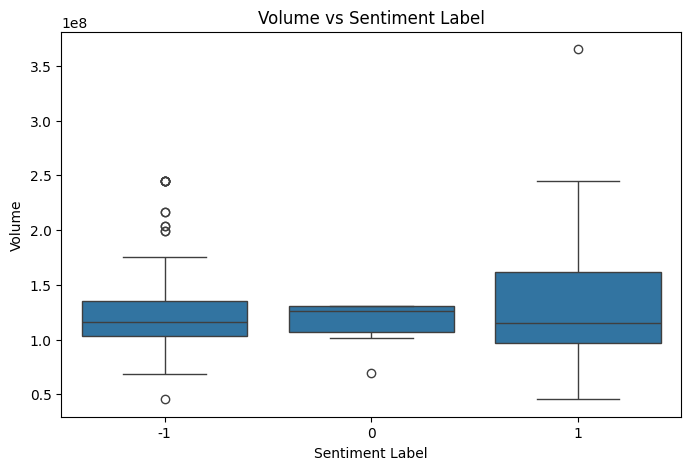

In [27]:
# Relationship between News Length and Price Change
plt.figure(figsize=(8, 5))
sns.scatterplot(data=data, x='News_Length', y='Price_Change', alpha=0.6)
plt.title('Price Change vs News Length')
plt.xlabel('News Length')
plt.ylabel('Price Change')
plt.show()

# Relationship between Word Count and Price Change
plt.figure(figsize=(8, 5))
sns.scatterplot(data=data, x='Word_Count', y='Price_Change', alpha=0.6)
plt.title('Price Change vs Word Count')
plt.xlabel('Word Count')
plt.ylabel('Price Change')
plt.show()

# Sentiment vs Volume
plt.figure(figsize=(8, 5))
sns.boxplot(data=data, x='Label', y='Volume')
plt.title('Volume vs Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Volume')
plt.show()

### Bivariate Analysis Results

The bivariate analysis revealed several insights:

*   **Correlation Matrix:** The correlation matrix showed high positive correlations among the 'Open', 'High', 'Low', and 'Close' prices, which is expected. 'Volume', 'News_Length', and 'Word_Count' showed relatively low correlations with the price features and with each other. This suggests that news characteristics and volume might capture different aspects of market activity not directly tied to daily price fluctuations in a linear manner.
*   **Sentiment Polarity vs Price Change:** The box plot of Price Change versus Sentiment Label suggests that there might be a slight difference in the distribution of price changes based on sentiment. Positive sentiment appears to be associated with a tendency towards positive price changes, while negative sentiment might be associated with negative or smaller positive price changes. Neutral sentiment shows a distribution centered around zero price change.
*   **Date vs Price/Volume:** The line plots of Close Price and Volume over time show the trends in stock price and trading activity over the analyzed period. This helps visualize the overall movement of the stock and identify any periods of high volatility or trading volume.
*   **News Length/Word Count vs Price Change:** The scatter plots of Price Change versus News Length and Word Count show no clear linear relationship. This indicates that simply the length or word count of a news article is not a strong direct predictor of the magnitude of the daily price change.
*   **Sentiment vs Volume:** The box plot of Volume versus Sentiment Label does not show a clear distinct pattern in trading volume based on the sentiment of the news. While there might be some variations in the median volume across sentiment categories, the distributions largely overlap.

These bivariate analyses provide a deeper understanding of the relationships between different features in the dataset and will inform the subsequent data preprocessing and model building steps.

## **Data Preprocessing**

## **Word Embeddings**

#### **Word2Vec**

### **Sentence Transformer**

## **Sentiment Analysis**

### **Model Evaluation Criterion**

**Note:**  
You can use the helper functions provided below to:
- Plot a **confusion matrix** (`plot_confusion_matrix`)
- Generate key **classification metrics** like accuracy, recall, precision, and F1-score (`model_performance_classification_sklearn`)

These are ready-to-use. However, you’re welcome to explore and write your own evaluation code if you prefer. Feel free to modify or extend these as per your learning goals!

##### **Utility Functions**

In [ ]:
def plot_confusion_matrix(actual, predicted):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    actual (array-like): The true labels.
    predicted (array-like): The predicted labels from the model.

    Returns:
    None: Displays the confusion matrix plot.
    """

    # Compute the confusion matrix.
    cm = confusion_matrix(actual, predicted)

    # Create a new figure with a specified size
    plt.figure(figsize=(5, 4))

    # Define the labels for the confusion matrix dynamically from the data
    label_list = sorted(list(np.unique(np.concatenate((actual, predicted)))))

    # Plot the confusion matrix using a heatmap with annotations
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_list, yticklabels=label_list)

    # Label for the y-axis
    plt.ylabel('Actual')

    # Label for the x-axis
    plt.xlabel('Predicted')

    # Title of the plot
    plt.title('Confusion Matrix')

    # Display the plot
    plt.show()

In [ ]:
def model_performance_classification_sklearn(actual, predicted):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    model (sklearn classifier): The classification model to evaluate.
    predictors (array-like): The independent variables used for predictions.
    target (array-like): The true labels for the dependent variable.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """

    # Compute Accuracy
    acc = accuracy_score(actual,predicted)
    # Compute Recall
    recall = recall_score(actual,predicted,average='weighted')
    # Compute Precision
    precision = precision_score(actual,predicted,average='weighted')
    # Compute F1-score
    f1 = f1_score(actual,predicted,average='weighted')

    # Create a DataFrame to store the computed metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )
    # Return the DataFrame with the metrics
    return df_perf

### **Build Random Forest Models using different text embeddings**

### **Building Neural Network Models using different text embeddings**

### **Model Performance Summary and Final Model Selection**

## **Conclusions and Recommendations**

-

<font size=6 color='blue'>Power Ahead</font>
___